In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from IPython.display import display

%matplotlib inline
sns.set()

C:\Users\Sam\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\Sam\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\Sam\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#grab specific columns of interest
peat_cols = ['decday', 'datetime', 'wm_gf', 'wm', 'wc_gf', 'gpp_ANNnight', 'er_ANNnight', 'wq_gf', 'TA.y', 'sal', 'PAR', 'VPD', 'PA.x', 
         'PRECIP', 'ustar', 'WT', 'H_gf', 'TW_WATER_10cm']

# import dataset
peat6 = pd.read_csv('data/peat6_all.csv', usecols=peat_cols)

#date time conversions
peat6['datetime'] = pd.to_datetime(peat6['datetime']) #convert datetime to correct type
peat6['year'] = peat6['datetime'].dt.year
peat6['month'] = peat6['datetime'].dt.month
peat6['DOY'] = peat6['datetime'].dt.day

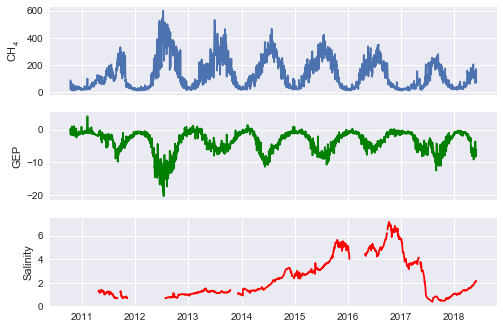

In [4]:
#aggregate to daily cumulative fluxes and mean environmental conditions
peat6['dday'] = peat6['decday'] // 1

daily = pd.DataFrame(peat6.groupby('dday')['wm_gf'].agg('mean')) * 12.01 * 3600 * 24 / 1E6
daily.columns = ['CH4']
daily['GEP'] = peat6.groupby('dday')['gpp_ANNnight'].agg('mean') * 12.01 * 3600 * 24 / 1E6
daily['Sal'] = peat6.groupby('dday')['sal'].agg('mean')
daily['Ta'] = peat6.groupby('dday')['TA.y'].agg('mean')
daily['datetime'] = peat6.groupby('dday')['datetime'].agg('min')

#plot daily fluxes of CH4, GEP, and mean salinity
fig, ax = plt.subplots(3, sharex='col')

ax[0].plot(daily['datetime'], daily['CH4'])
ax[0].set_ylabel('$\mathregular{CH_{4}}$')
ax[1].plot(daily['datetime'], daily['GEP'], color='green')
ax[1].set_ylabel('GEP')
ax[2].plot(daily['datetime'], daily['Sal'], color='red')
ax[2].set_ylabel('Salinity')

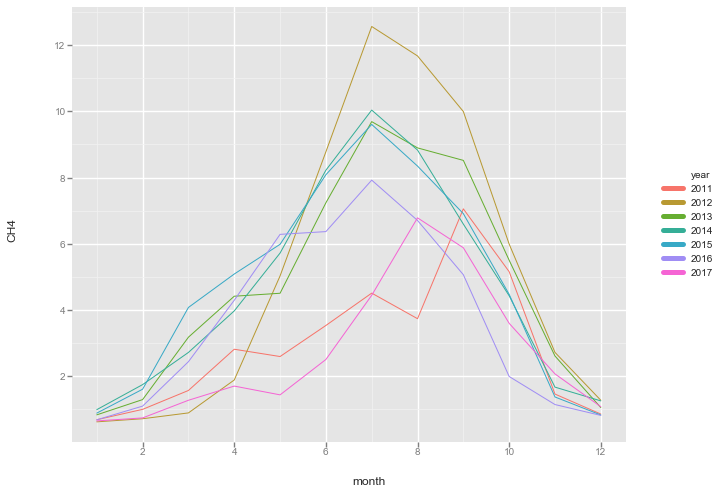

<ggplot: (-9223371912190527151)>

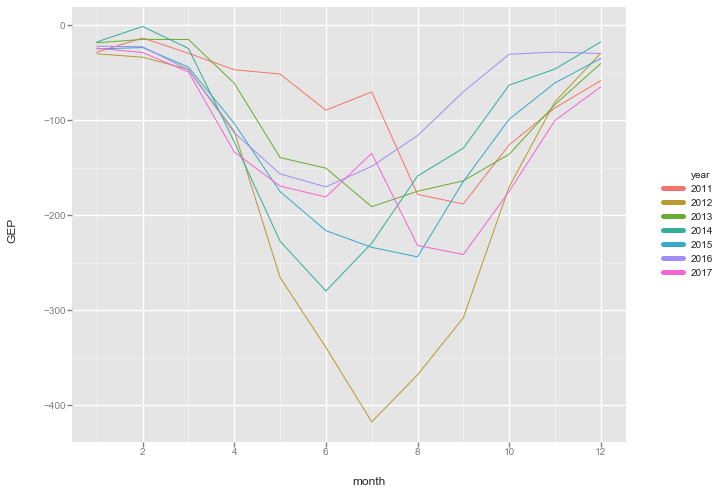

<ggplot: (-9223371912183933717)>

In [11]:
#aggregate
monthly = pd.DataFrame(peat6.groupby(['month', 'year'])['wm_gf'].agg(np.nanmean)) * 12.01 * 3600 * 24 * 30 / 1E9
monthly.columns = ['CH4']
monthly['GEP'] = peat6.groupby(['month', 'year'])['gpp_ANNnight'].agg(np.nanmean) * 12 * 3600 * 24 * 30 / 1E6
monthly=monthly.reset_index()

#filter incomplete years
monthly = monthly.query('year > 2010 & year < 2018')
monthly['year'] = monthly['year'].astype(object)

g = ggplot(monthly, aes(x='month', y='CH4', colour='year')) + geom_line()
h = ggplot(monthly, aes(x='month', y='GEP', colour='year')) + geom_line()
display(g, h)


In [10]:
peat6.groupby(['month', 'year'])['gpp_ANNnight'].agg(np.nanmean) * 12 * 3600 * 24 * 30 / 1E6


month  year
1      2011    -28.470018
       2012    -30.170451
       2013    -18.548792
       2014    -17.648639
       2015    -24.995653
       2016    -22.104603
       2017    -24.168541
       2018    -24.361757
2      2011    -13.468749
       2012    -33.716411
       2013    -14.966115
       2014     -1.398543
       2015    -23.575904
       2016    -22.684679
       2017    -28.859359
       2018    -31.792007
3      2011    -29.574868
       2012    -46.516689
       2013    -15.053002
       2014    -24.498587
       2015    -44.089665
       2016    -46.956921
       2017    -49.197480
       2018    -34.307695
4      2011    -46.882816
       2012   -111.539857
       2013    -61.124449
       2014   -122.689124
       2015   -103.413381
       2016   -113.137878
                  ...    
9      2012   -307.767366
       2013   -163.711873
       2014   -129.393730
       2015   -164.311113
       2016    -70.074734
       2017   -241.242080
10     2010    -21.199643
